In [1]:
from prepyto import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import ConnectionPatch
plt.rcParams.update({'font.size': 20})

2022-02-22 11:38:38.291669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-packages/numpydoc/docscrape.py:434: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Points layer to the layer list. 
...
  warn(msg)
/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-packages/numpydoc/docscrape.py:434: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Labels layer to the layer list. 
...
  warn(msg)
/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-packages/numpydoc/docscrape.py:434: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Shapes layer to the layer list. 
...
  warn(msg)
/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-packages/numpydoc/docscrape.py:434: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Surface layer to the layer list. 
...
  warn(msg)
/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-

In [2]:
pl = Pipeline('/mnt/data/amin/Handpicked/84')

Prepyto Pipeline: the pipeline is created for /mnt/data/amin/Handpicked/84


In [3]:
pl.set_array('image')
pl.set_array('deep_labels')

'deep_labels'

In [4]:
vesicle_regions = pd.DataFrame(skimage.measure.regionprops_table(pl.deep_labels,properties=('centroid', 'label', 'bbox')))
bboxes = get_bboxes_from_regions(vesicle_regions)
centroids = get_centroids_from_regions(vesicle_regions)
labels = get_labels_from_regions(vesicle_regions)
thicknesses, densities, radii, centers, kept_labels = [],[],[],[],[]

In [5]:
shifts = []
delta_radii = []
new_centroids = []
new_radii = []
for i in tqdm(range(len(labels))):
    label = labels[i]
    rounded_centroid = np.round(centroids[i]).astype(np.int)
    radius = get_label_largest_radius(bboxes[i])
    margin = 3
    _, _, new_centroid, new_optimal_radius, _ = get_sphere_parameters(pl.image, label, margin, radius, rounded_centroid)
    new_centroids.append(new_centroid)
    new_radii.append(new_optimal_radius)
    shift = new_centroid - rounded_centroid
    delta_radius = new_optimal_radius - radius
    shifts.append(shift)
    delta_radii.append(delta_radius)
new_centroids = np.array(new_centroids)
new_radii = np.array(new_radii)
shifts = np.array(shifts)
delta_radii = np.array(delta_radii)
distances = np.linalg.norm(shifts, axis=1)


  0%|                                                                                                                                                                                                                                            | 0/503 [00:00<?, ?it/s]/tmp/ipykernel_607056/2697496428.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rounded_centroid = np.round(centroids[i]).astype(np.int)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [89]:
import pandas as pd
sphere_df

,thickness,density,radius,center,mahalanobis
label,,,,,
1,8,-1.657473,25,"[29, 186, 387]",0.580932
2,6,-1.504027,21,"[27, 191, 232]",1.263134
3,10,-1.630919,25,"[28, 202, 282]",2.050415
4,8,-1.989893,25,"[33, 229, 450]",1.521812
5,8,-1.888967,21,"[31, 232, 379]",1.010920
...,...,...,...,...,...
523,8,-1.973325,19,"[253, 418, 274]",1.724611
524,8,-1.302598,21,"[255, 794, 548]",0.504659
526,8,-1.503821,21,"[254, 162, 139]",0.625353


In [88]:
sphere_df= pd.read_pickle("/mnt/data/amin/Handpicked/84/prepyto/Dummy_84_trim.rec_sphere_dataframe.pkl")
del sphere_df['radials']
del sphere_df['p']
del sphere_df['corr']
sphere_df['radius'].loc[1]=25

/home/amin/anaconda3/envs/deep_vesicles/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [59]:
new_radii = sphere_df["radius"].values
new_centroids = sphere_df["center"].values
new_centroids = new_centroids.tolist()
new_centroids_arr = [x.tolist() for x in new_centroids]
new_centroids = np.array(new_centroids_arr)

In [6]:
from scipy.spatial import distance_matrix

In [7]:
np.shape(dm)

NameError: name 'dm' is not defined

In [8]:
rm = np.repeat(np.array((new_radii,)), len(new_radii),axis=0)
radii_matrix = rm + rm.T
dm = distance_matrix(new_centroids, new_centroids)
maxvalue = np.finfo(dm.dtype).max
for i in range(len(dm)):
    dm[i,i] = maxvalue
collisions = np.array((np.where(dm < radii_matrix)))
collision_counts = np.array(np.unique(collisions[0], return_counts=True))
collision_count_dict = {}
for x,y in collision_counts.T:
    collision_count_dict[x]=y

In [9]:
print(collisions.T)
print(collision_counts.T)

[[  1  33]
 [  4  95]
 [ 10  42]
 [ 11  47]
 [ 31  51]
 [ 33   1]
 [ 40  48]
 [ 42  10]
 [ 47  11]
 [ 47  69]
 [ 48  40]
 [ 51  31]
 [ 52  79]
 [ 52 118]
 [ 61  85]
 [ 63 105]
 [ 69  47]
 [ 69  70]
 [ 70  69]
 [ 70 121]
 [ 71  77]
 [ 77  71]
 [ 79  52]
 [ 85  61]
 [ 89 126]
 [ 95   4]
 [104 181]
 [105  63]
 [109 116]
 [109 153]
 [110 142]
 [116 109]
 [118  52]
 [119 204]
 [121  70]
 [122 141]
 [124 164]
 [125 190]
 [126  89]
 [141 122]
 [142 110]
 [151 239]
 [153 109]
 [164 124]
 [181 104]
 [181 272]
 [189 248]
 [190 125]
 [195 295]
 [204 119]
 [204 304]
 [206 241]
 [206 281]
 [210 320]
 [227 327]
 [232 261]
 [239 151]
 [239 353]
 [241 206]
 [241 306]
 [242 339]
 [248 189]
 [248 252]
 [252 248]
 [255 264]
 [258 314]
 [261 232]
 [263 344]
 [264 255]
 [269 392]
 [272 181]
 [273 282]
 [273 379]
 [274 359]
 [277 281]
 [277 394]
 [281 206]
 [281 277]
 [282 273]
 [286 351]
 [288 341]
 [291 390]
 [295 195]
 [295 413]
 [302 401]
 [304 204]
 [306 241]
 [314 258]
 [320 210]
 [320 353]
 [322 420]

In [10]:
plt.hist(collision_counts[1], bins=counts[1].max()-1)

NameError: name 'counts' is not defined

distance: 1.48 ± 1.83
distance median : 1.41


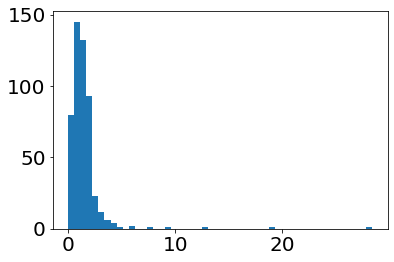

radial change: 2.96 ± 1.41
absoliute radial change media: 3.00


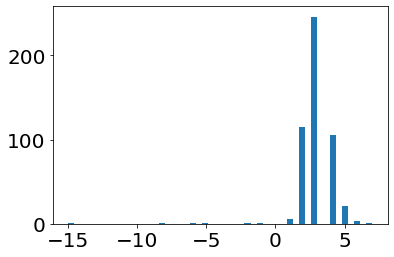

In [11]:



print(f"distance: {distances.mean():.2f} ± {distances.std():.2f}")
print(f"distance median : {np.median(distances):.2f}")
_= plt.hist(distances, bins=50)
plt.show()
print(f"radial change: {delta_radii.mean():.2f} ± {delta_radii.std():.2f}")
print(f"absoliute radial change media: {np.median(np.abs(delta_radii)):.2f}")
_ = plt.hist(delta_radii, bins=50)

In [16]:
def make_figure(i, savefig=False):
    fontsize = 32
    margin = 3
    radius = get_label_largest_radius(bboxes[i])  #this is an integer
    rounded_centroid = np.round(centroids[i]).astype(np.int) #this is an array of integers
    label = labels[i]
    print(label)
    image_box = extract_box_of_radius(pl.image, rounded_centroid, radius + margin)
    origin = None
    radial_profile = get_radial_profile(image_box, origin)
    i_membrane_center, _ = get_sphere_membrane_center_and_density_from_radial_profile(radial_profile)
    i_upper_limit = get_radial_profile_i_upper_limit(radial_profile)
    i_membrane_outer_halo = i_membrane_center + radial_profile[i_membrane_center:i_upper_limit].argmax()
    derivative2 = np.diff(radial_profile,2)
    filtered_derivative2 = ndimage.gaussian_filter1d(derivative2,1)
    optimal_radius = -1 + i_membrane_center + ndimage.gaussian_filter1d(derivative2[i_membrane_center:i_membrane_outer_halo+1],1).argmin()
    average_image = get_3d_radial_average(image_box, origin)
    _, _, new_centroid, new_optimal_radius, _ = get_sphere_parameters(pl.image, label, margin, radius, rounded_centroid)
    new_optimal_radius = new_optimal_radius - 1 
    shift = new_centroid - rounded_centroid
    new_image_box = extract_box_of_radius(pl.image, new_centroid, new_optimal_radius + margin+1)
    print(f"new image box shape is {new_image_box.shape}")
    print(f"new centroid is {new_centroid}")
    new_radial_profile = get_radial_profile(new_image_box,origin)
    new_average_image = get_3d_radial_average(new_image_box, origin)
    new_i_membrane_center, _ = get_sphere_membrane_center_and_density_from_radial_profile(new_radial_profile)
    new_i_upper_limit = get_radial_profile_i_upper_limit(new_radial_profile)
    new_i_membrane_outer_halo = new_i_membrane_center + new_radial_profile[new_i_membrane_center:new_i_upper_limit].argmax()
    new_derivative2 = np.diff(new_radial_profile,2)
    new_filtered_derivative2 = ndimage.gaussian_filter1d(new_derivative2,1)
    print(f"new_optimal_radius is {new_optimal_radius}")
    print(f"alternative calc: {-1 + new_i_membrane_center + new_filtered_derivative2[i_membrane_center:i_membrane_outer_halo+1].argmin()}")
    
    nx = 4
    ny = 2
    dxs = 8
    dys = 6
    theta = np.linspace(0, 2*np.pi, 100)
    xcircle = optimal_radius * np.cos(theta)
    ycircle = optimal_radius * np.sin(theta)
    new_xcircle = new_optimal_radius * np.cos(theta)
    new_ycircle = new_optimal_radius * np.sin(theta)
    
    fig, ax = plt.subplots(nrows=ny,ncols=nx, figsize=(nx*dxs,ny*dys), facecolor='white')
    #fig.subplots_adjust(hspace=0.5)
    #fig.suptitle(f"i = {i},   shift = {shift},  radius difference = {new_optimal_radius - optimal_radius}, avg min,max = {average_image.min():.2f}, {average_image.max():.2f} ,  new_avg min,max = {new_average_image.min():.2f}, {new_average_image.max():.2f}")
    
    ax[0,1].plot(radial_profile)
    ax[0,1].set_xlabel('radius [pixel]')
    ax[0,1].set_ylabel('intensity')
    ylim = ax[0,1].get_ylim()
    ax[0,1].fill_between((i_membrane_center,i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[0,1].vlines(optimal_radius, ylim[0], ylim[1],color='red')
    ax[0,1].set_ylim(ylim)
    
    ax[0,2].plot(filtered_derivative2)
    ax[0,2].set_xlabel('radius [pixel]')
    ax[0,2].set_ylabel(r'$\frac{\partial^2 intensity}{\partial radius^2}$', fontsize=28)
    ylim = ax[0,2].get_ylim()
    ax[0,2].fill_between((i_membrane_center,i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[0,2].vlines(optimal_radius, ylim[0], ylim[1],color='red')
    ax[0,2].set_ylim(ylim)
    ax[0,2].set_xlim(ax[0,1].get_xlim())
    
    ax[1,1].plot(new_radial_profile)
    ax[1,1].set_xlabel('radius [pixel]')
    ax[1,1].set_ylabel('intensity')
    ylim = ax[1,1].get_ylim()
    ax[1,1].fill_between((new_i_membrane_center,new_i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[1,1].vlines(new_optimal_radius,ylim[0], ylim[1],color='red')
    ax[1,1].set_ylim(ylim)
    ax[1,1].set_xlim(ax[0,1].get_xlim())
    
    ax[1,2].set_xlabel('radius [pixel]')
    ax[1,2].set_ylabel(r'$\frac{\partial^2 intensity}{\partial radius^2}$', fontsize=28)
    ax[1,2].plot(new_filtered_derivative2)
    ylim = ax[1,2].get_ylim()
    ax[1,2].fill_between((new_i_membrane_center,new_i_membrane_outer_halo), ylim[0], ylim[1], alpha=0.2)
    ax[1,2].vlines(new_optimal_radius, ylim[0], ylim[1],color='red')
    ax[1,2].set_ylim(ylim)
    ax[1,2].set_xlim(ax[0,1].get_xlim())

    imgplt00 = ax[0,0].imshow(image_box[image_box.shape[0]//2])
    ax[0,0].set_xlabel('x-coordinate [pixel]')
    ax[0,0].set_ylabel('y-coordinate [pixel]')
    imgplt00.set_cmap('gray')
    xlim, ylim = (ax[0,0].get_xlim(), ax[0,0].get_ylim())
    ax[0,0].plot(xcircle+image_box.shape[1]//2, ycircle+image_box.shape[2]//2, color='red')
    ax[0,0].set_xlim(xlim)
    ax[0,0].set_ylim(ylim)
    
    imgplt01 = ax[0,3].imshow(-average_image[image_box.shape[0]//2])
    ax[0,3].set_xlabel('x-coordinate [pixel]')
    ax[0,3].set_ylabel('y-coordinate [pixel]')
    imgplt01.set_cmap('copper')
    xlim, ylim = (ax[0,3].get_xlim(), ax[0,3].get_ylim())
    ax[0,3].plot(xcircle+image_box.shape[1]//2, ycircle+image_box.shape[2]//2, color='red')
    ax[0,3].set_xlim(xlim)
    ax[0,3].set_ylim(ylim)
    
    imgplt10 = ax[1,0].imshow(new_image_box[new_image_box.shape[0]//2])
    ax[1,0].set_xlabel('x-coordinate [pixel]')
    ax[1,0].set_ylabel('y-coordinate [pixel]')
    imgplt10.set_cmap('gray')
    xlim, ylim = (ax[1,0].get_xlim(), ax[1,0].get_ylim())
    ax[1,0].plot(new_xcircle+new_image_box.shape[1]//2, new_ycircle+new_image_box.shape[2]//2, color='red')
    ax[1,0].set_xlim(xlim)
    ax[1,0].set_ylim(ylim)

    imgplt11 = ax[1,3].imshow(-new_average_image[new_image_box.shape[0]//2])
    ax[1,3].set_xlabel('x-coordinate [pixel]')
    ax[1,3].set_ylabel('y-coordinate [pixel]')
    imgplt11.set_cmap('copper')
    xlim, ylim = (ax[1,3].get_xlim(), ax[1,0].get_ylim())
    ax[1,3].plot(new_xcircle+new_image_box.shape[1]//2, new_ycircle+new_image_box.shape[2]//2, color='red')
    ax[1,3].set_xlim(xlim)
    ax[1,3].set_ylim(ylim)   

    ax[0,0].text(0.05, 0.95, "A", transform=ax[0,0].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,1].text(0.05, 0.95, "B", transform=ax[0,1].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,2].text(0.05, 0.95, "C", transform=ax[0,2].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[0,3].text(0.05, 0.95, "D", transform=ax[0,3].transAxes,fontsize=fontsize, fontweight='bold', va='top', color='white')
    ax[1,0].text(0.05, 0.95, "E", transform=ax[1,0].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,1].text(0.05, 0.95, "F", transform=ax[1,1].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,2].text(0.05, 0.95, "G", transform=ax[1,2].transAxes,fontsize=fontsize, fontweight='bold', va='top')
    ax[1,3].text(0.05, 0.95, "H", transform=ax[1,3].transAxes,fontsize=fontsize, fontweight='bold', va='top', color='white')
    
    fig.tight_layout(h_pad=7.5)
    
    ax[0,0].annotate(f"Initial radius = {radius}. Radius after inital radial profile = {optimal_radius}.\nShift [z x y] = {shift}\nFinal radius = {new_optimal_radius}", (1.1,-0.48), xycoords='axes fraction', annotation_clip=False, fontsize=24)
    
    xyA = (1, -.2)
    xyB = (1, 1.2)
    coordsA = "axes fraction"
    coordsB = "axes fraction"
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax[0,0], axesB=ax[1,0],
                      arrowstyle="Simple, head_length=2, head_width=2",
                    facecolor="white", linewidth=3)
    ax[0,0].add_artist(con)
    print(f"i is {i}")
    if savefig:
        plt.savefig(f'fig{i:03d}.svg')
    else:
        plt.show()
          
          

In [17]:
#i = next(i_s)
#print(f"i = {i}")
for k, count in collision_count_dict.items():
    if count ==15:
        make_figure(k)

In [18]:
for i in (162,152,144,139,118,99):
    make_figure(i, savefig=True)

IndexError: index 162 is out of bounds for axis 0 with size 68

In [ ]:
for i in range(centroids.shape[0]):
    try:
        make_figure(i)
    except ValueError:
        print(f"missed {i}")

In [ ]:
for i in (11,):
    make_figure(i, savefig=True)


/tmp/ipykernel_607056/3948738387.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rounded_centroid = np.round(centroids[i]).astype(np.int) #this is an array of integers


3
new image box shape is (56, 56, 56)
new centroid is [ 28 202 282]
new_optimal_radius is 24
alternative calc: 24
i is 2


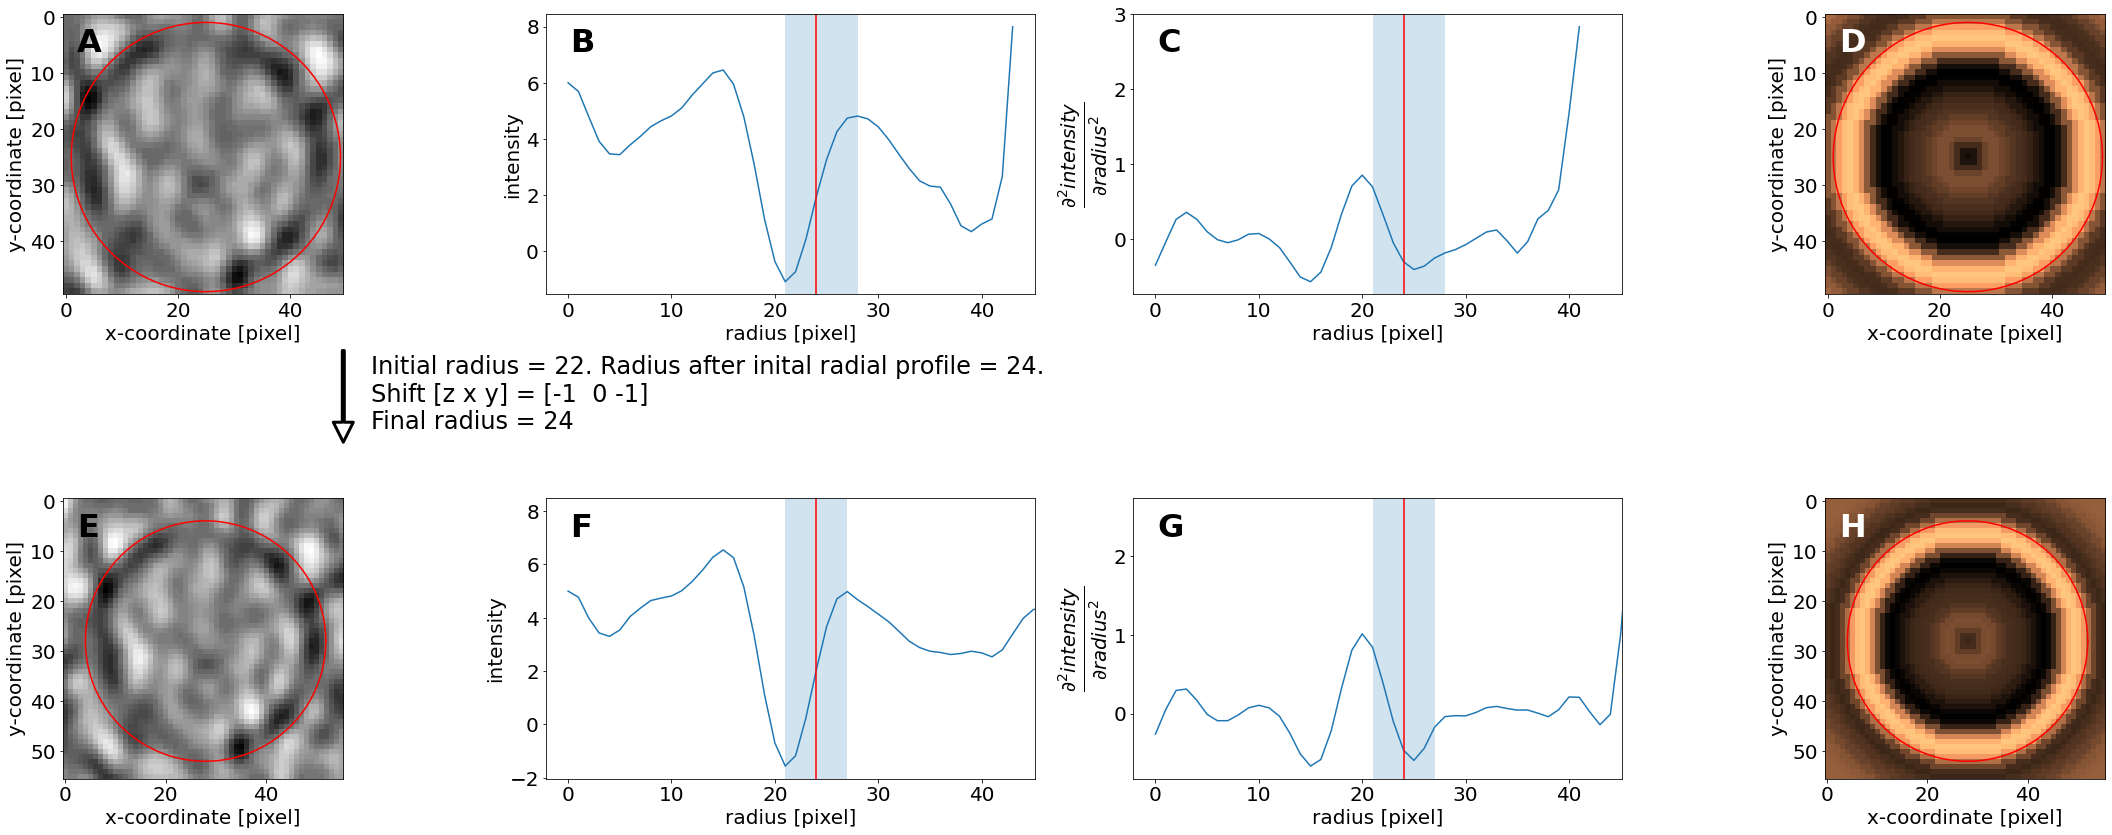

In [18]:
make_figure(2)

In [15]:
labels

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  53,  55,  56,  57,  58,
        59,  60,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 19